In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.style.use('ggplot')
mpl.rcParams["figure.dpi"] = 96
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('customer_data.csv')

In [3]:
# Filtra las filas con valores nulos en la columna "Income"
observaciones_nulas = data[data['Income'].isnull()]
# Calcula la proporción de nulos en la columna "Income"
proporcion_nulos = data['Income'].isnull().mean()

# Muestra la proporción de nulos
print("Proporción de nulos en la columna 'Income': {:.2%}".format(proporcion_nulos))
print(observaciones_nulas)

Proporción de nulos en la columna 'Income': 1.07%
         ID  Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome   
10     1994        1983  Graduation        Married     NaN        1         0  \
27     5255        1986  Graduation         Single     NaN        1         0   
43     7281        1959         PhD         Single     NaN        0         0   
48     7244        1951  Graduation         Single     NaN        2         1   
58     8557        1982  Graduation         Single     NaN        1         0   
71    10629        1973    2n Cycle        Married     NaN        1         0   
90     8996        1957         PhD        Married     NaN        2         1   
91     9235        1957  Graduation         Single     NaN        1         1   
92     5798        1973      Master       Together     NaN        0         0   
128    8268        1961         PhD        Married     NaN        0         1   
133    1295        1963  Graduation        Married     NaN 

In [4]:
# Eliminar valores nulos
data = data.dropna()

# Convertir la columna 'Dt_Customer' a tipo datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

# Establecer la fecha de referencia como 1 mes después de la máxima fecha en 'Dt_Customer'
fecha_referencia = data['Dt_Customer'].max() + pd.DateOffset(months=1)

# Crear columna que representa la antigüedad del cliente en semanas y redondear a 2 decimales
data['Antiq_Level'] = ((fecha_referencia - data['Dt_Customer']).dt.total_seconds() / (7 * 24 * 60 * 60)).round(2)

# Convertir la columna 'Year_Birth' a tipo datetime
data['Year_Birth'] = pd.to_datetime(data['Year_Birth'], format='%Y')

# Calcular la edad referenciando a la observación más reciente
data['Age'] = ((fecha_referencia - data['Year_Birth']).dt.days // 365).astype(int)

# Sumar total de gastos por categoría
data['Total_Spending'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                               'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Definir los límites de los rangos etarios y las etiquetas correspondientes
bins = [18, 25, 35, 50, 65, float('inf')]  # Definir los límites de los rangos, comenzando en 18
labels = ['19-25', '26-35', '36-50', '51-65', '65+']  # Etiquetas para los rangos

# Crear la nueva variable de rango etario
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Eliminar categorías despreciables de 'Marital_Status'
data = data[~data['Marital_Status'].isin(['Alone', 'Absurd', 'YOLO'])]

# Eliminar columnas
data = data.drop(['Year_Birth', 'Dt_Customer', 'ID'], axis=1)
data.reset_index(drop=True, inplace=True)

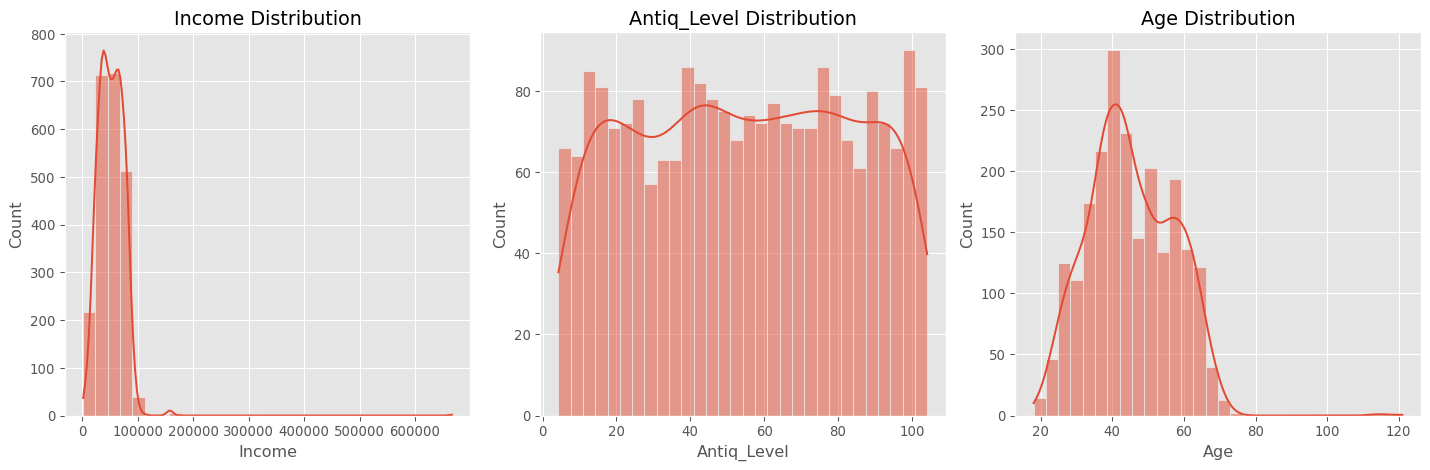

In [5]:
# Crear subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Histograma de Income
sns.histplot(data['Income'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Income Distribution')

# Histograma de Antiq_Level
sns.histplot(data['Antiq_Level'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Antiq_Level Distribution')

# Histograma de Age
sns.histplot(data['Age'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Age Distribution')

plt.tight_layout()
plt.show();

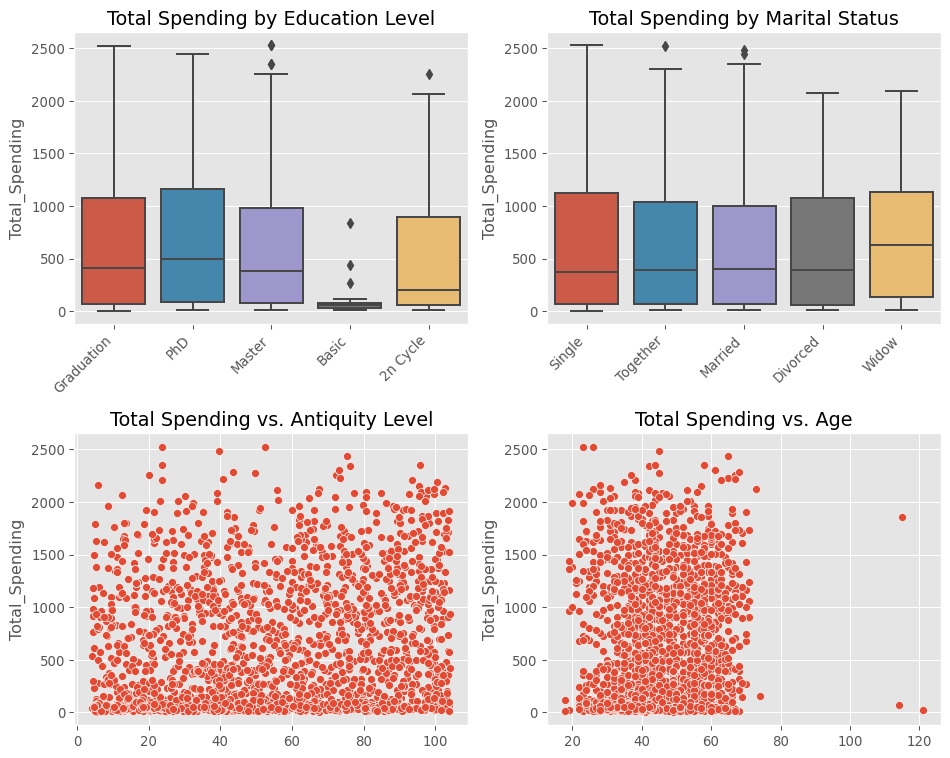

In [6]:
# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Subplot para 'Education'
sns.boxplot(data=data, x='Education', y='Total_Spending', ax=axes[0, 0])
axes[0, 0].set_title('Total Spending by Education Level')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_xlabel('')

# Subplot para 'Marital_Status'
sns.boxplot(data=data, x='Marital_Status', y='Total_Spending', ax=axes[0, 1])
axes[0, 1].set_title('Total Spending by Marital Status')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_xlabel('')

# Subplot para 'Antiq_Level'
sns.scatterplot(data=data, x='Antiq_Level', y='Total_Spending', ax=axes[1, 0])
axes[1, 0].set_title('Total Spending vs. Antiquity Level')
axes[1, 0].set_xlabel('')  

# Subplot para 'Age'
sns.scatterplot(data=data, x='Age', y='Total_Spending', ax=axes[1, 1])
axes[1, 1].set_title('Total Spending vs. Age')
axes[1, 1].set_xlabel('')  

plt.tight_layout()
plt.show();

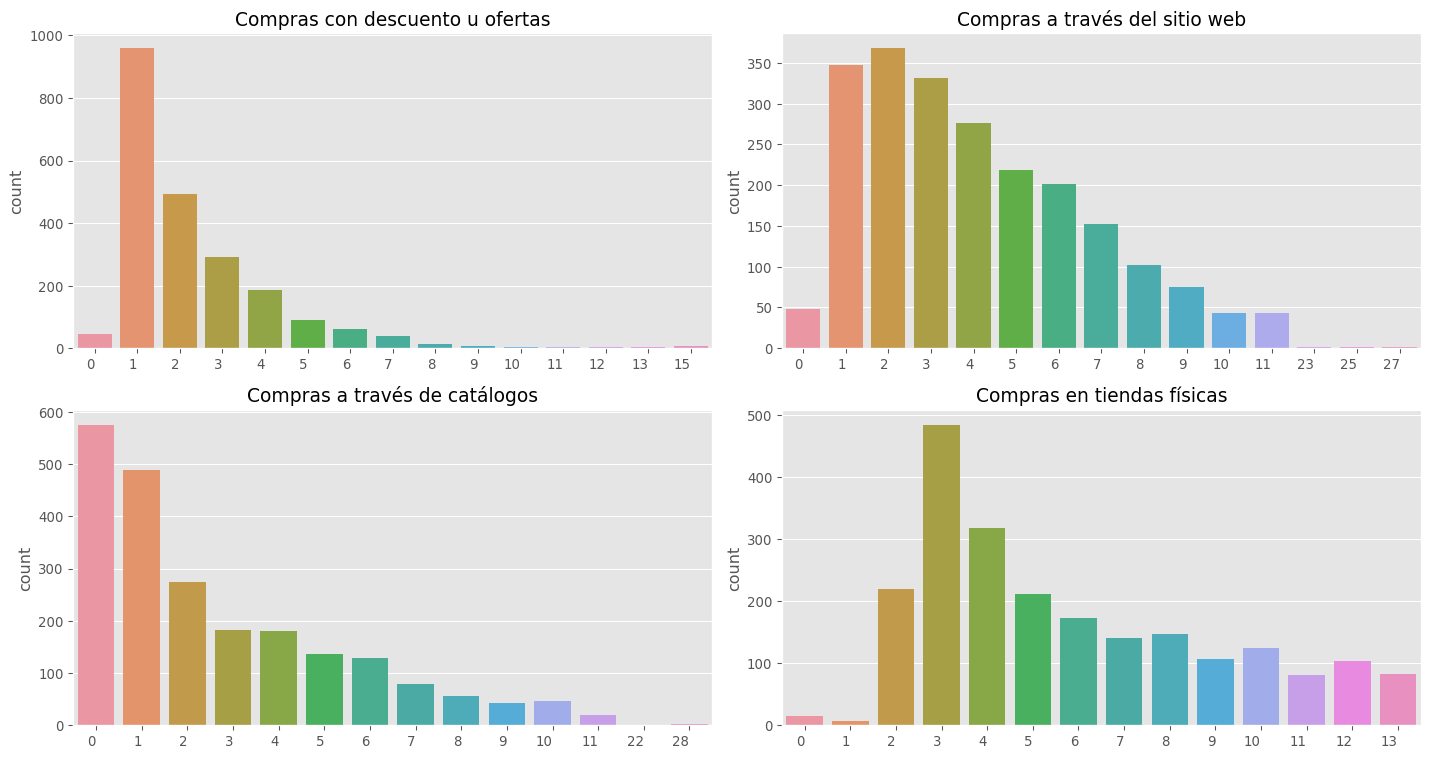

In [7]:
# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Definir las variables a graficar
variables = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
descriptions = [
    'Compras con descuento u ofertas',
    'Compras a través del sitio web',
    'Compras a través de catálogos',
    'Compras en tiendas físicas']

# Crear los subplots y asignar títulos
for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2
    sns.countplot(data=data, x=variable, ax=axes[row, col])
    axes[row, col].set_title(descriptions[i], fontsize=14)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), ha='right')
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show();

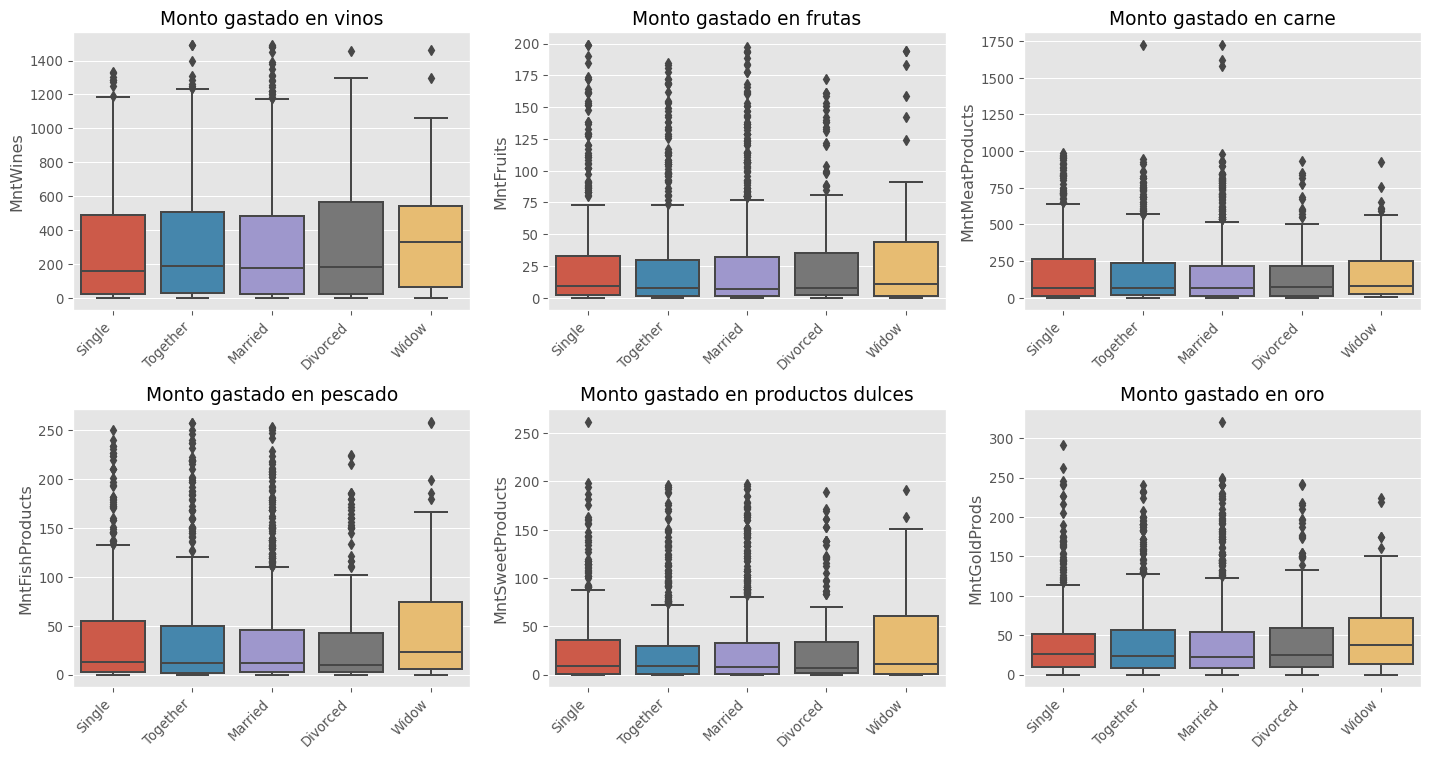

In [8]:
# Variables a graficar
variables = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
descriptions = [
    'Monto gastado en vinos',
    'Monto gastado en frutas',
    'Monto gastado en carne',
    'Monto gastado en pescado',
    'Monto gastado en productos dulces',
    'Monto gastado en oro']

# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Iterar sobre las variables y crear un boxplot para cada una
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.boxplot(data=data, x='Marital_Status', y=var, ax=axes[row, col])
    axes[row, col].set_title(descriptions[i], fontsize=14)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel(var)

plt.tight_layout()
plt.show();

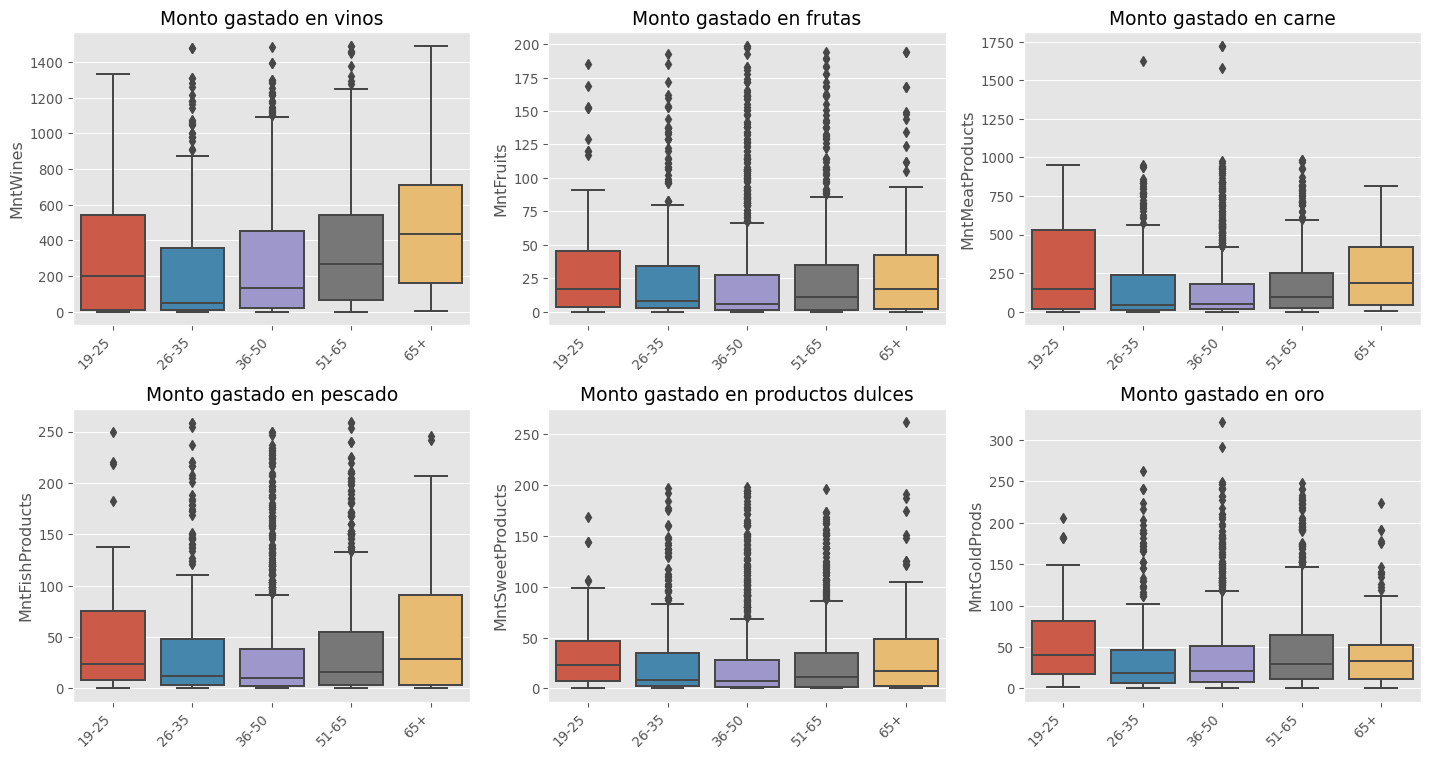

In [9]:
# Variables a graficar
variables = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
descriptions = [
    'Monto gastado en vinos',
    'Monto gastado en frutas',
    'Monto gastado en carne',
    'Monto gastado en pescado',
    'Monto gastado en productos dulces',
    'Monto gastado en oro']

# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Iterar sobre las variables y crear un boxplot para cada una
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.boxplot(data=data, x='Age_Group', y=var, ax=axes[row, col])
    axes[row, col].set_title(descriptions[i], fontsize=14)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel(var)

plt.tight_layout()
plt.show();

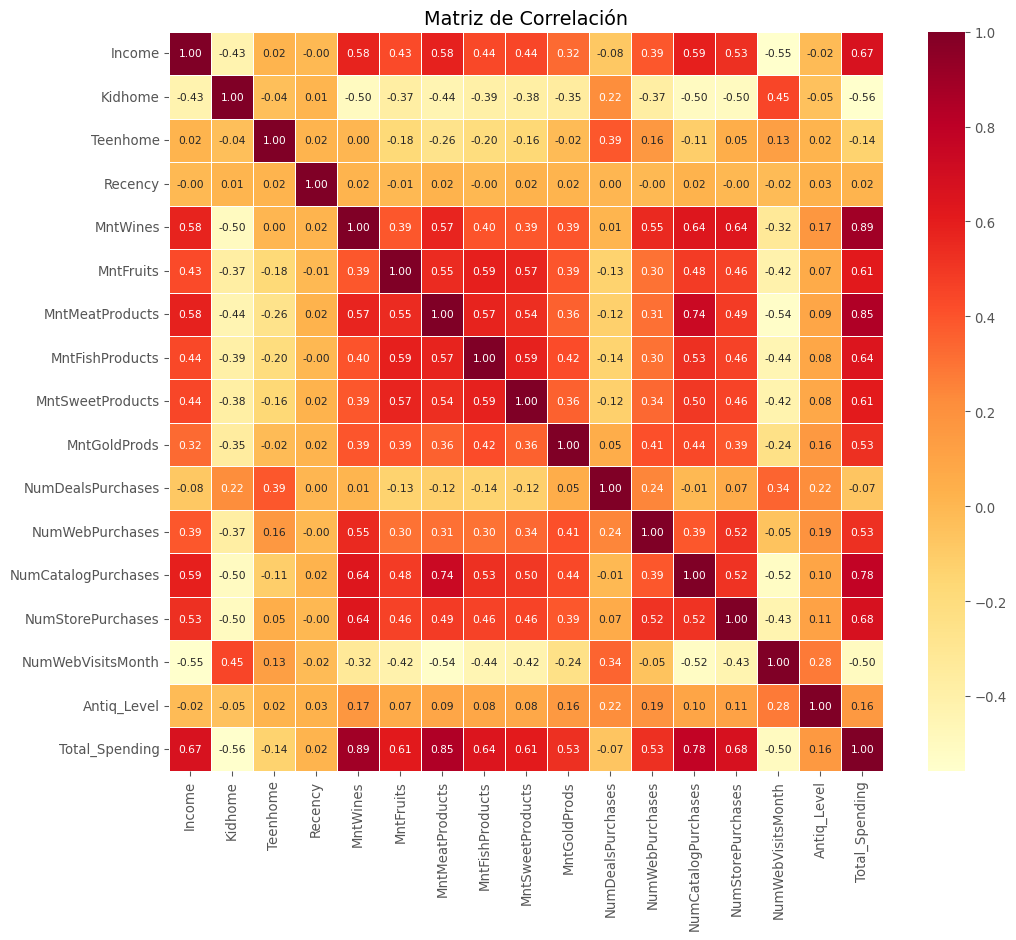

In [10]:
data = data.drop(columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp3', 'AcceptedCmp2',
                            'Z_CostContact', 'Z_Revenue','AcceptedCmp1','Complain','Response'], axis = 1)

# Filtrar solo las columnas numéricas
numeric_data = data.select_dtypes(include=['int32', 'int64', 'float64'])

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', linewidths=.5, fmt=".2f", annot_kws={"size": 8})
plt.title('Matriz de Correlación')
plt.show();

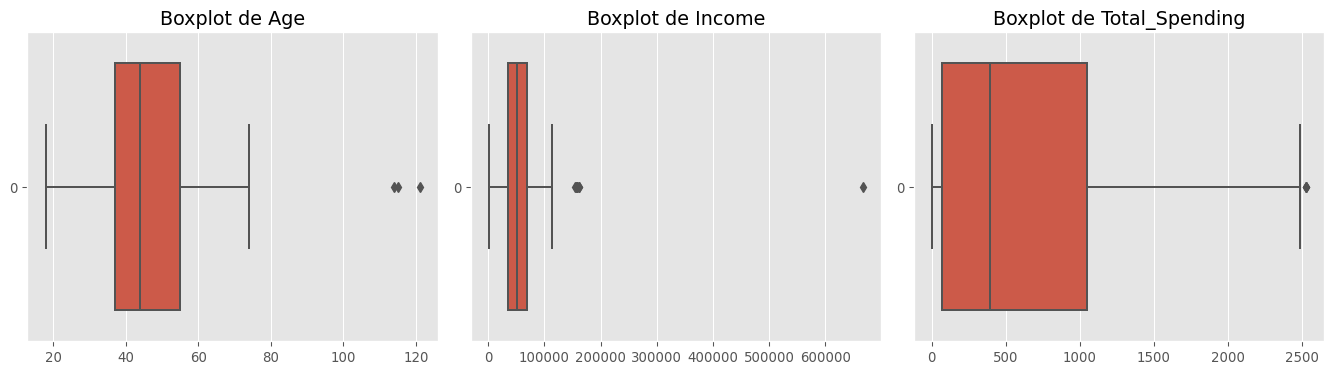

In [11]:
# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# Seleccionar las columnas de interés
selected_columns = ['Age', 'Income', 'Total_Spending']

# Crear boxplots para cada variable en subplots
for i, col in enumerate(selected_columns):
    sns.boxplot(data=data[col], ax=axes[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show();

In [12]:
# Filtrar observaciones con más de 100 años
age_filter = data['Age'] > 100
observations_over_100_years = data[age_filter]

# Filtrar observaciones con ingreso mayor a 600,000
income_filter = data['Income'] > 600000
observations_high_income = data[income_filter]

# Mostrar los resultados
print("Observaciones con más de 100 años:")
print(observations_over_100_years)

print("\nObservaciones con ingreso mayor a 600,000:")
print(observations_high_income)

Observaciones con más de 100 años:
    Education Marital_Status   Income  Kidhome  Teenhome  Recency  MntWines   
178  2n Cycle       Divorced  36640.0        1         0       99        15  \
225  2n Cycle         Single  60182.0        0         1       23         8   
323       PhD       Together  83532.0        0         0       36       755   

     MntFruits  MntMeatProducts  MntFishProducts  ...  MntGoldProds   
178          6                8                7  ...            25  \
225          0                5                7  ...             2   
323        144              562              104  ...           224   

     NumDealsPurchases  NumWebPurchases  NumCatalogPurchases   
178                  1                2                    1  \
225                  1                1                    0   
323                  1                4                    6   

     NumStorePurchases  NumWebVisitsMonth  Antiq_Level  Age  Total_Spending   
178                  2     

In [13]:
# Crear filtros
age_filter = data['Age'] > 100
income_filter = data['Income'] > 600000

# Combinar los filtros con el operador lógico OR
combined_filter = age_filter | income_filter

# Eliminar las observaciones que cumplen con el filtro combinado
data = data.drop(data[combined_filter].index)

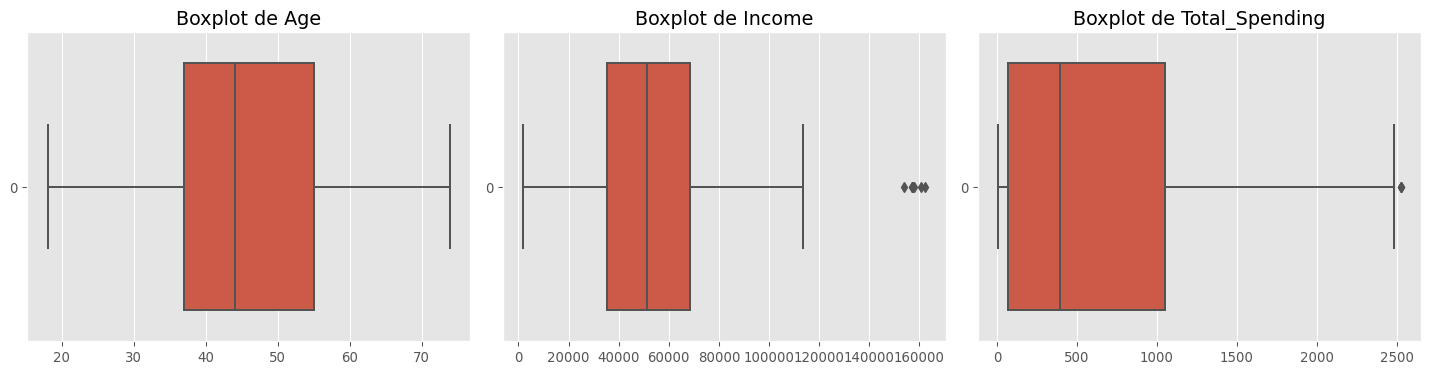

In [14]:
# Configurar el tamaño de la figura y los subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Seleccionar las columnas de interés
selected_columns = ['Age', 'Income', 'Total_Spending']

# Crear boxplots para cada variable en subplots
for i, col in enumerate(selected_columns):
    sns.boxplot(data=data[col], ax=axes[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show();

In [15]:
# Crear variables dummy para las columnas 'Education', 'Marital_Status', y 'Age_Group'
data = pd.get_dummies(data, columns=['Education', 'Marital_Status', 'Age_Group'], drop_first=True, dummy_na=False)

bool_columns = data.select_dtypes(include='bool').columns

data[bool_columns] = data[bool_columns].astype(int)

Se procede a realizar el escalamiento de los datos para la aplicación de PCA. En lugar de seleccionar arbitrariamente la cantidad de dimensiones a reducir, se opta por elegir el número de dimensiones que capturen una porción significativa de la varianza total, específicamente, al menos el 95%. Se lleva a cabo una primera ejecución de PCA sin reducir la dimensionalidad, con el propósito de calcular la cantidad mínima de dimensiones necesarias para preservar al menos el 95% de la varianza en los datos. Este enfoque proporciona una base sólida para la toma de decisiones en cuanto a la reducción de dimensionalidad, garantizando la retención de una cantidad significativa de información original en el conjunto de datos transformado.

El número óptimo de dimensiones obtenido en este proceso, servirá para implementar posteriormente la segmentación o clusterización.

In [16]:
# Seleccionar las características para PCA
features_for_pca = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
                    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                    'NumStorePurchases', 'NumWebVisitsMonth', 'Antiq_Level', 'Age', 'Total_Spending',
                    'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD',
                    'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together',
                    'Marital_Status_Widow', 'Age_Group_26-35', 'Age_Group_36-50', 'Age_Group_51-65', 'Age_Group_65+']

# Seleccionar las características y escalar los datos
data_for_pca = data[features_for_pca]
scaler = StandardScaler()
data_for_pca_scaled = scaler.fit_transform(data_for_pca)

# Aplicar PCA
pca_full = PCA(random_state = 21, svd_solver = 'full')
pca_full.fit(data_for_pca_scaled)

# Calcular la cantidad mínima de dimensiones para preservar el 95% de la varianza
explained_variance_ratio_cumsum = pca_full.explained_variance_ratio_.cumsum()
# Encontrar la cantidad más cercana al 95%
target_variance = 0.95
dimensions_for_target_variance = np.argmin(np.abs(explained_variance_ratio_cumsum - target_variance)) + 1

print("Cantidad de dimensiones:", dimensions_for_target_variance)

Cantidad de dimensiones: 21


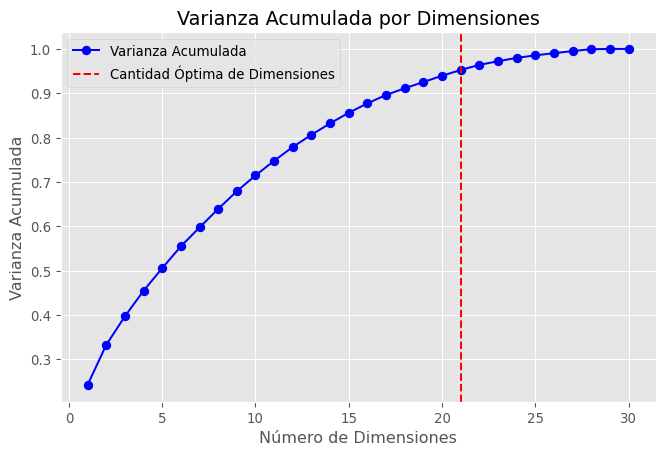

In [17]:
# Calcular la cantidad de dimensiones
dimensions = range(1, len(explained_variance_ratio_cumsum) + 1)

# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(dimensions, explained_variance_ratio_cumsum, marker='o', linestyle='-', color='b', label='Varianza Acumulada')
plt.axvline(x=dimensions_for_target_variance, color='r', linestyle='--', label='Cantidad Óptima de Dimensiones')

plt.title('Varianza Acumulada por Dimensiones')
plt.xlabel('Número de Dimensiones')
plt.ylabel('Varianza Acumulada')
plt.legend()
plt.grid(True)
plt.show();

In [18]:
# Aplicar PCA con la cantidad óptima de dimensiones
pca = PCA(n_components=dimensions_for_target_variance, random_state=23, svd_solver='full')

data_reduced = pd.DataFrame(pca.fit_transform(data_for_pca_scaled), 
                            columns=[f'PC{i}' for i in range(1, dimensions_for_target_variance + 1)])



data_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,4.354251,-0.142871,0.576115,-2.307798,1.810475,-0.276993,-1.342545,-0.500144,0.934082,0.745151,...,-0.888964,-1.869082,0.838363,-0.124799,0.617841,-0.978489,1.471715,-0.215186,0.767216,0.774307
1,-2.304259,1.247883,-1.684738,-2.154381,-0.301818,0.141528,-1.858084,-1.209636,-0.453066,-0.443772,...,-0.461809,-0.069853,0.767577,0.553844,0.139327,-0.150580,0.035687,-0.484702,-0.530885,0.108854
2,1.817971,-0.568515,0.501452,-0.541690,-0.853151,1.907587,0.674047,0.915869,-0.074462,-0.325739,...,-0.244777,0.463984,-0.874302,-0.620729,-0.493263,-0.946070,-0.838547,0.694802,0.427201,0.743772
3,-2.806438,-2.147495,-0.958477,-1.148727,0.821218,0.531624,1.366547,1.137103,-1.082936,-1.576287,...,0.357226,0.658331,0.183743,0.314632,-0.099213,-0.277594,-0.181206,0.156343,0.088145,0.030001
4,-0.491500,-1.316028,-0.191601,1.758862,0.956387,-1.962485,0.231206,0.842996,-1.791225,-0.321768,...,0.641177,0.834518,1.973777,-0.185478,0.087533,-0.312384,-0.150242,0.306710,0.541678,-0.039058


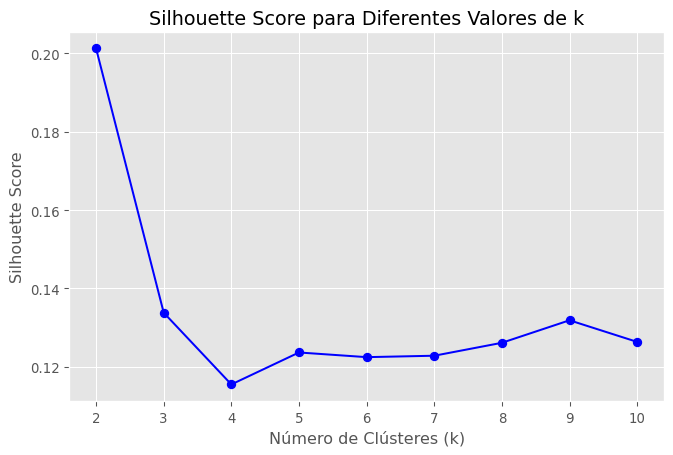

In [19]:
# Lista para almacenar los silhouette scores
silhouette_scores = []

# Rango de k (número de clústeres)
k_values = range(2, 11)

for k in k_values:
    # Inicializar y ajustar el modelo de KMeans
    kmeans = KMeans(n_clusters=k, random_state=25)
    kmeans.fit(data_reduced)

    # Predecir los clústeres
    labels = kmeans.predict(data_reduced)

    # Calcular el silhouette score
    silhouette_avg = silhouette_score(data_reduced, labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar el valor de k que maximiza el silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Graficar el silhouette score en función de k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score para Diferentes Valores de k')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show();

El método de la puntuación de silueta para encontrar el número óptimo de clústeres (k), generalmente se busca el valor de k que maximiza la puntuación de silueta. La puntuación de silueta oscila entre -1 y 1, donde un valor más alto indica que los objetos están mejor ajustados a sus propios clústeres y peor ajustados a los clústeres vecinos. Un valor cercano a 1 sugiere una buena configuración de clústeres.

Entonces, al observar la variación de la puntuación de silueta para diferentes valores de k, el valor máximo que indica es 2, lo que sugiere una buena separación entre clústeres en ese número específico.

In [20]:
k_optimo = 2

# Inicializar el modelo K-means con el número óptimo de clusters
kmeans_model = KMeans(n_clusters=k_optimo, random_state=24)

# Entrenar el modelo con los datos reducidos
kmeans_model.fit(data_reduced)

# Obtener las etiquetas de clúster asignadas por K-means
labels_kmeans = kmeans_model.labels_

# Agregar las etiquetas de clúster al dataframe 'data'
data['Cluster_Labels'] = labels_kmeans

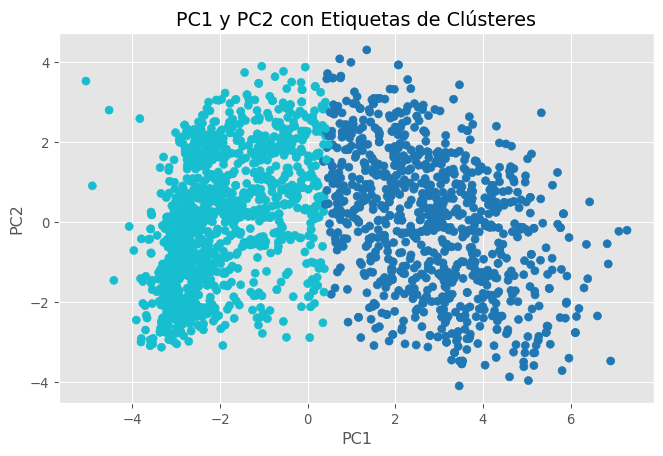

In [21]:
# Gráfico en 2D (usando PC1 y PC2)
plt.figure(figsize=(8, 5))
plt.scatter(data_reduced['PC1'], data_reduced['PC2'], c=data['Cluster_Labels'], cmap='tab10')
plt.title('PC1 y PC2 con Etiquetas de Clústeres')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show();

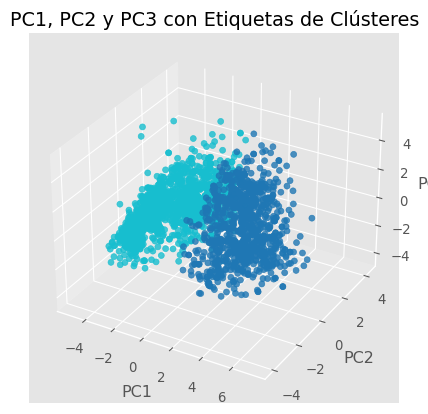

In [22]:
# Gráfico en 3D (usando PC1, PC2 y PC3)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_reduced['PC1'], data_reduced['PC2'], data_reduced['PC3'], 
           c=data['Cluster_Labels'], cmap='tab10', alpha=0.8)
ax.set_title('PC1, PC2 y PC3 con Etiquetas de Clústeres')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show();

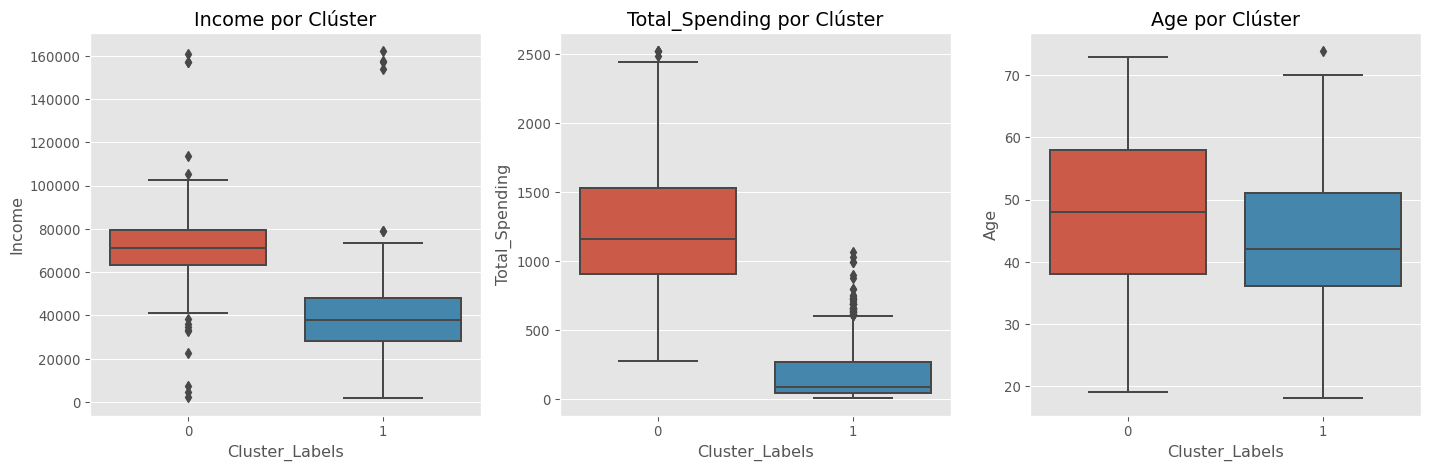

In [23]:
# Seleccionar características importantes
features_of_interest = ['Income', 'Total_Spending', 'Age']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Crear diagrama de caja para cada característica por clúster
for i, feature in enumerate(features_of_interest):
    sns.boxplot(x='Cluster_Labels', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} por Clúster')

plt.tight_layout()
plt.show()

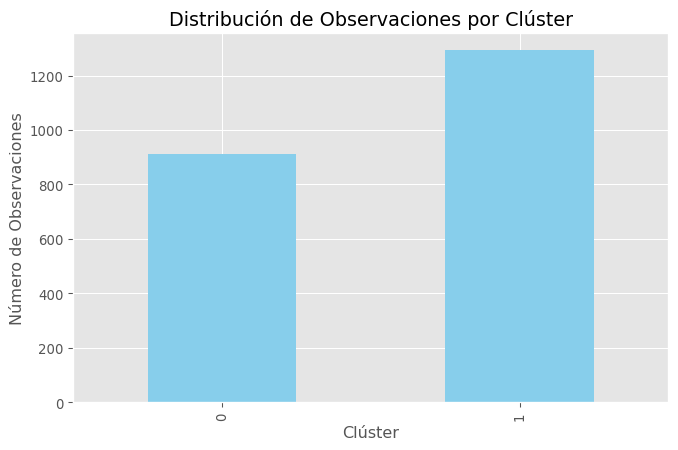

In [24]:
plt.figure(figsize=(8, 5))
data['Cluster_Labels'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Observaciones por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Número de Observaciones')
plt.show()

In [25]:
# Agrupar por la columna de etiquetas de cluster y calcular la media
cluster_means = data.groupby('Cluster_Labels').mean()

# Mostrar el DataFrame resultante
print(cluster_means)

                      Income   Kidhome  Teenhome    Recency    MntWines   
Cluster_Labels                                                            
0               71184.876096  0.066886  0.451754  49.175439  606.540570  \
1               38390.812065  0.706110  0.543697  49.017788   92.979118   

                MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts   
Cluster_Labels                                                                  
0               54.262061       353.402412        76.930921         56.302632  \
1                6.625677        35.856922         9.803558          6.489559   

                MntGoldProds  ...  Education_Master  Education_PhD   
Cluster_Labels                ...                                    
0                  74.655702  ...          0.146930       0.248904  \
1                  22.045630  ...          0.177108       0.193349   

                Marital_Status_Married  Marital_Status_Single   
Cluster_Labels              

Tomando el resultado de la segmentación, se puede realizar la siguiente caracterización y comparación de ambos clústeres.

**Cluster 0:**

**Income:** Este cluster tiene un ingreso promedio más alto (71,184.88) en comparación con el Cluster 1, lo que sugiere que representa a individuos con mayores recursos financieros.

**Kidhome, Teenhome:** Las proporciones más bajas de hogares con niños y adolescentes indican que este grupo tiende a tener menos responsabilidades familiares.

**Recency:** La recencia más alta (49.18) sugiere que los miembros de este cluster han realizado compras más recientes en comparación con el Cluster 1.

**MntWines, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds:** Gastos más altos en estas categorías sugieren un mayor interés o capacidad para gastar en productos de lujo o especializados.

**NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases:** Números más altos de compras a través de diferentes canales indican un mayor nivel de actividad de compra.

**NumWebVisitsMonth:** La media más alta de visitas mensuales al sitio web sugiere una mayor interacción en línea.

**Antiq_Level:** El nivel de antigüedad relativamente alto indica que los miembros de este cluster han estado en la base de datos por un período más largo.

**Age:** La edad media es de 58.16 años, lo que sugiere que este cluster puede estar compuesto en su mayoría por individuos mayores.

**Total_Spending:** El gasto total (1,222.09) también es significativamente más alto en comparación con el Cluster 1.

**Cluster 1:**

**Income:** El ingreso promedio es más bajo (38,390.81) en comparación con el Cluster 0, sugiriendo una situación financiera menos holgada.

**Kidhome, Teenhome:** Proporciones más altas de hogares con niños y adolescentes indican una mayor carga familiar en comparación con el Cluster 0.

**Recency:** La recencia ligeramente más baja (49.02) sugiere que los miembros de este cluster pueden haber realizado compras ligeramente menos recientes.

**MntWines, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds:** Gastos más bajos en estas categorías indican un menor interés o capacidad para gastar en productos de lujo.

**NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases:** Números más bajos de compras a través de diferentes canales indican un menor nivel de actividad de compra en comparación con el Cluster 0.

**NumWebVisitsMonth:** La media más baja de visitas mensuales al sitio web sugiere una menor interacción en línea.

**Antiq_Level:** El nivel de antigüedad más bajo indica que los miembros de este cluster han estado en la base de datos por un período más corto.

**Age:** La edad media es de 52.45 años, lo que sugiere una composición de edad más joven en comparación con el Cluster 0.

**Total_Spending:** El gasto total (173.80) también es significativamente más bajo en comparación con el Cluster 0.
